# UAVSAR

```{admonition} Learning Objectives
*A 15 minute guide to UAVSAR data for SnowEX*
- overview of UAVSAR data (both InSAR and PolSAR products)
- demonstrate how to access and transform data
- use Python raster libraries [rioxarray](https://corteva.github.io/rioxarray) and [hvplot](https://hvplot.holoviz.org)
```

```{figure} ../../img/UAVSAR_plane.jpg
---
height: 400px
name: UAVSAR
---
## Picture of UAVSAR. [Source](https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/)
```


Intro slide deck: https://uavsar.jpl.nasa.gov/education/what-is-uavsar.html 

In [42]:
# import libraries
import re
import zipfile
import getpass
from osgeo import gdal 
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
import codecs # for text parsing code
import glob # for listing files in tiff conversion function
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx

#from osgeo import gdal # for GetRasterBand, Open, ReadAsArray
#import matplotlib
#import matplotlib.pylab as plb # for add_patch, add_subplot, figure, hist, imshow, set_title, xaxis,_label, text 
#import matplotlib.patches as patches  # for Rectangle
#import matplotlib.animation as an # for FuncAnimation
#import subprocess

## What is UAVSAR?

UAVSAR stands for uninhabited aerial vehicle synthetic apeterature radar. It is a suborbital (airplane) remote sensing instrument operated out of NASA JPL.

| frequency | resolution (rng x azi m) | swath width (km) |
| - | - | - | 
| L-band (23 cm) | 1.8 | 16 | 

Documentation:
* https://uavsar.jpl.nasa.gov/science/documents.html
* https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/

## NASA SnowEx 2020 and 2021 UAVSAR Campaings

During the winter of 2020 and 2021, NASA conducted an L-band InSAR timeseris at a seris of sites across the Western US with the goal of tracking changes in SWE. Get site coordinate from HP to make map!!!!

```{figure} ../../img/SnowEx2020.png
---
height: 400px
name: UAVSAR map
---
##Map of the UAVSAR flight locations for NASA SnowEx. [Source](Chris Hiemstra)
```


## Data Access

There are multiple ways to access UAVSAR data. Also the SQL database.

* [Alaska Satellite Facility Vertex Portal](https://search.asf.alaska.edu/#/?dataset=UAVSAR)
* [NASA Earthdata Suborbital Search](https://search.earthdata.nasa.gov/portal/suborbital/search?fi=UAVSAR&as[instrument][0]=UAVSAR)
* [JPL UAVSAR Data Search](https://uavsar.jpl.nasa.gov/cgi-bin/data.pl)

## Data Types



```{admonition} InSAR Data Types
:class: InSAR Data Types
- ANN file (.ann): a text annotation file with metadata
- AMP files (.amp1 and .amp2): calibrated multi-looked amplitude products
- INT files (.int): interferogram product, complex number format (we won't be using these here)
- COR files (.cor): interferometric correlation product, a measure of the noise level of the phase
- GRD files (.grd): interferometric products projected to the ground in simple geographic coordinates (latitude, longitude)
- HGT file: the DEM that was used in the InSAR processing
- KML and KMZ files (.kml or .kmz): format for viewing files in Google Earth (can't be used for analysis)
```

```{admonition} PolSAR Data Types
:class: PolSAR Data Types
-
```

## Converting Data to GeoTiffs

The downloadable UAVSAR data comes in a flat binary format, which is not readable by GDAL. Therefore it needs to be transformed for use in standard spatial analysis software (ArcGIS, QGIS, Python, R, MATLAB, etc.) To do this, we will use the uavsar_tiff_convert function, which takes information (latitude, longitude, number of lines and samples, data type, pixel size) from the annotation file to create an ENVI header (.hdr). Once the ENVI header is created, the files can be read into Python and converted to GeoTiffs.

In [37]:
# folder is path to a folder with an .ann (or .txt) and .grd files (.amp1, .amp2, .cor, .unw, .int)

def uavsar_tiff_convert(folder):
    """
    Builds a header file for the input UAVSAR .grd file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .grd and .ann files
    """


    os.chdir(folder)
    int_file = glob.glob(os.path.join(folder, 'int.grd'))

    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Latitude_list = []
    Longitude_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".grd":
            newfile = open(files[0:-4] + ".hdr", 'w')
            newfile.write("""ENVI
description = {DESCFIELD}
samples = NSAMP
lines = NLINE
bands = 1
header offset = 0
data type = DATTYPE
interleave = bsq
sensor type = UAVSAR L-Band
byte order = 0
map info = {Geographic Lat/Lon, 
            1.000, 
            1.000, 
            LON, 
            LAT,  
            0.0000555600000000, 
            0.0000555600000000, 
            WGS-84, units=Degrees}
wavelength units = Unknown
                """
                          )
            newfile.close()
            if files[0:18] not in Files_list:
                Files_list.append(files[0:18])

    #Variables used to recall indexed values.
    var1 = 0

    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types.
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "Ground Range Data Latitude Lines" in line:
                    Lines = line[65:70]
                    print(Lines)
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "Ground Range Data Longitude Samples" in line:
                    Samples = line[65:70]
                    print(Samples)
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)

                elif "Ground Range Data Starting Latitude" in line:
                    Latitude = line[65:85]
                    print(Latitude)
                    if Latitude not in Latitude_list:
                        Latitude_list.append(Latitude)

                elif "Ground Range Data Starting Longitude" in line:
                    Longitude = line[65:85]
                    print(Longitude)
                    if Longitude not in Longitude_list:
                        Longitude_list.append(Longitude)
    
                        
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .grd files expect for .int
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = DATTYPE" in line:
                        sources.write(re.sub(line[12:19], "4", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
    
    # Step 3: Open .hdr file and replace data for .int file date type 6 (complex)                 
    for files in os.listdir(folder):
        if files[-8:] == ".int.hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = 4" in line:
                        sources.write(re.sub(line[12:13], "6", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
                        
    
    # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
    # once loaded in we use gdal.Translate to convert and save as a .tiff
    
    # Dan, if you wanted to convert to UTM, it would probably be best in this step
    # but also possibly when making the header, where lat/lon is specified 
    
    data_to_process = glob.glob(os.path.join(folder, '*.grd')) # list all .grd files
    for data_path in data_to_process: # loop to open and translate .grd to .tiff, and save .tiffs using gdal
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float32)
    
    # Step 5: Save the .int raster, needs seperate save because of the complex format
    data_to_process = glob.glob(os.path.join(folder, '*.int.grd')) # list all .int.grd files (only 1)
    for data_path in data_to_process:
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_CFloat32)

    print(".tiffs have been created")
    return

In [21]:
# directory in which the notebook resides
if 'tutorial_home_dir' not in globals():
    tutorial_home_dir = os.getcwd()
print("Notebook directory: ", tutorial_home_dir)

# directory for data downloads
data_dir = os.path.join(tutorial_home_dir,'data')

os.makedirs(data_dir, exist_ok=True)

Notebook directory:  /home/jovyan/website/book/tutorials/sar


In [8]:
# Update this with YOUR NASA Earthdata login to download SLC data
ASF_USER = input("Enter Username: ")
ASF_PASS = getpass.getpass("Enter Password: ")

files = ['https://datapool.asf.alaska.edu/AMPLITUDE_GRD/UA/rockmt_32109_21017-013_21021-001_0012d_s01_L090_01_amp_grd.zip',
         'https://datapool.asf.alaska.edu/METADATA/UA/rockmt_32109_21017-013_21021-001_0012d_s01_L090_01_ann.zip',
         'https://datapool.asf.alaska.edu/DEM_TIFF/UA/rockmt_32109_21017-013_21021-001_0012d_s01_L090_01_hgt_grd_tiff.zip']
         
if len(ASF_USER)==0 or len(ASF_PASS)==0:
    raise Exception("Specifiy your ASF password and user (earthdata log-in)")
    
for file in files:
    filename = os.path.basename(file)
    
    if not os.path.exists(os.path.join(data_dir,filename)):
        cmd = "wget {0} --user={1} --password={2} -P {3} -nc".format(file, ASF_USER, ASF_PASS, data_dir)
        print(f"Downloading: {file}")
        os.system(cmd)
    else:
        print(filename + " already exists. Skipping download ..")

Enter Username:  jacktarricone
Enter Password:  ············


Downloading: https://datapool.asf.alaska.edu/AMPLITUDE_GRD/UA/rockmt_32109_21017-013_21021-001_0012d_s01_L090_01_amp_grd.zip
Downloading: https://datapool.asf.alaska.edu/METADATA/UA/rockmt_32109_21017-013_21021-001_0012d_s01_L090_01_ann.zip
Downloading: https://datapool.asf.alaska.edu/DEM_TIFF/UA/rockmt_32109_21017-013_21021-001_0012d_s01_L090_01_hgt_grd_tiff.zip


In [20]:
# unzip files just downloaded, this is broken and is looping over and filling up the memory
with zipfile.ZipFile("/home/jovyan/website/book/tutorials/sar/data/rockmt_32109_21017-013_21021-001_0012d_s01_L090_01_ann.zip", "r") as zip_ref:
    zip_ref.extractall('/home/jovyan/website/book/tutorials/sar/data')

In [33]:
# remove zipped files
data_folder = "/home/jovyan/website/book/tutorials/sar/data/"
files_in_directory = os.listdir(data_folder)
zip_files = [file for file in files_in_directory if file.endswith(".zip")]
print(zip_files)

[]


In [35]:
# remove zip files and check to see if work
for file in zip_files:
    path_to_file = os.path.join(data_folder, file)
    os.remove(path_to_file)
data = os.listdir(data_folder)
print(data)

['rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.amp2.grd', 'rockmt_32109_21017-013_21021-001_0012d_s01_L090HV_01.ann', '.ipynb_checkpoints', 'rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.amp1.grd', 'rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.hgt.grd']


In [43]:
uavsar_tiff_convert(data_folder)

12447
13426
40.924106999999999  
-106.316282400000006
.tiffs have been created


In [44]:
# amplitude from the first aquisition
for amp1 in glob.glob("*amp1.grd.tiff"):
    print(amp1)
    
# amplitude from the second aquisition
for amp2 in glob.glob("*amp1.grd.tiff"):
    print(amp1)

# coherence
#for cor in glob.glob("*cor.grd.tiff"):
 #   print(cor)

# unwrapped phase
#for unw in glob.glob("*unw.grd.tiff"):
 #   print(unw)

# dem used in processing
for dem in glob.glob("*hgt.grd.tiff"):
    print(dem)

rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.amp1.grd.tiff
rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.amp1.grd.tiff
rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.hgt.grd.tiff


In [45]:
amp1_rast = rio.open(amp1)
amp2_rast = rio.open(amp2)
#cor_rast = rio.open(cor)
#unw_rast = rio.open(unw)
dem_rast = rio.open(dem)

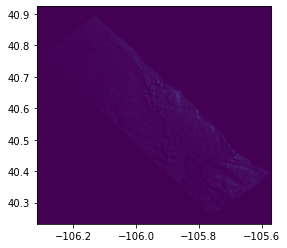

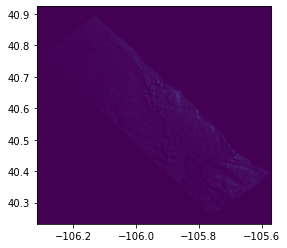

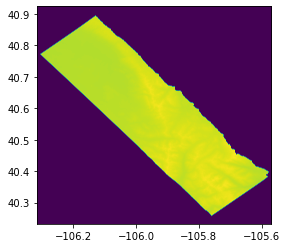

<AxesSubplot:>

In [46]:
show(amp1_rast)
show(amp2_rast)
#show(cor_rast)
#show(unw_rast)
show(dem_rast)

## Quick facts

| frequency | resolution (rng x azi m) | swath width (km) |
| - | - | - | 
| L-band | 1.8 | 16 | 

Documentation:
* https://uavsar.jpl.nasa.gov/science/documents.html
* https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/

Data Access:

* [NASA Earthdata Suborbital Search](https://search.earthdata.nasa.gov/portal/suborbital/search?fi=UAVSAR&as[instrument][0]=UAVSAR)
* [ASF Vertex SnowEx Grand Mesa Campaign]

`https://search.asf.alaska.edu/#/?dataset=UAVSAR&mission=Grand%20Mesa,%20CO&resultsLoaded=true&granule=UA_grmesa_27416_21019-017_21021-005_0006d_s01_L090_01-AMPLITUDE_GRD&zoom=3&center=-92.747866,10.530273&productTypes=AMPLITUDE_GRD`

## API data access